## Desafío - Árboles de Regresión

**Nombre alumno: Juan Pablo Ramírez**

Profesor: Heriberto Briceño - Gonzalo Seguel.

Generación: **G-16**

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la seccióncorrespondiente.

### Descripción
* Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos.
* Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable Sale_Price.

#### Ejercicio 1: Preparación del ambiente de trabajo
* Importe las librerías clásicas a utilizar.
* Para este ejercicio implementaremos árboles de regresión, por lo que deberá importar la clase DecisionTreeRegressor.
* De manera adicional importe las funciones y clases necesarias para generar un desempeño de métricas en problemas de regresión, división de muestras y búsqueda de grilla con validación cruzada.
* Elimine la columna 'Unnamed: 0' cuando cargue los datos.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import missingno as msno
import pickle

# Métodos asociados a regularización
from sklearn.metrics import classification_report, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Especificaciones
warnings.filterwarnings(action= 'ignore')
plt.style.use('seaborn-whitegrid')

# Funciones propias
from d7_funciones import *

In [2]:
df = pd.read_csv('ames_housing.csv').drop(columns=['Unnamed: 0'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   int64  
 3   Lot_Area            2930 non-null   int64  
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

<AxesSubplot:>

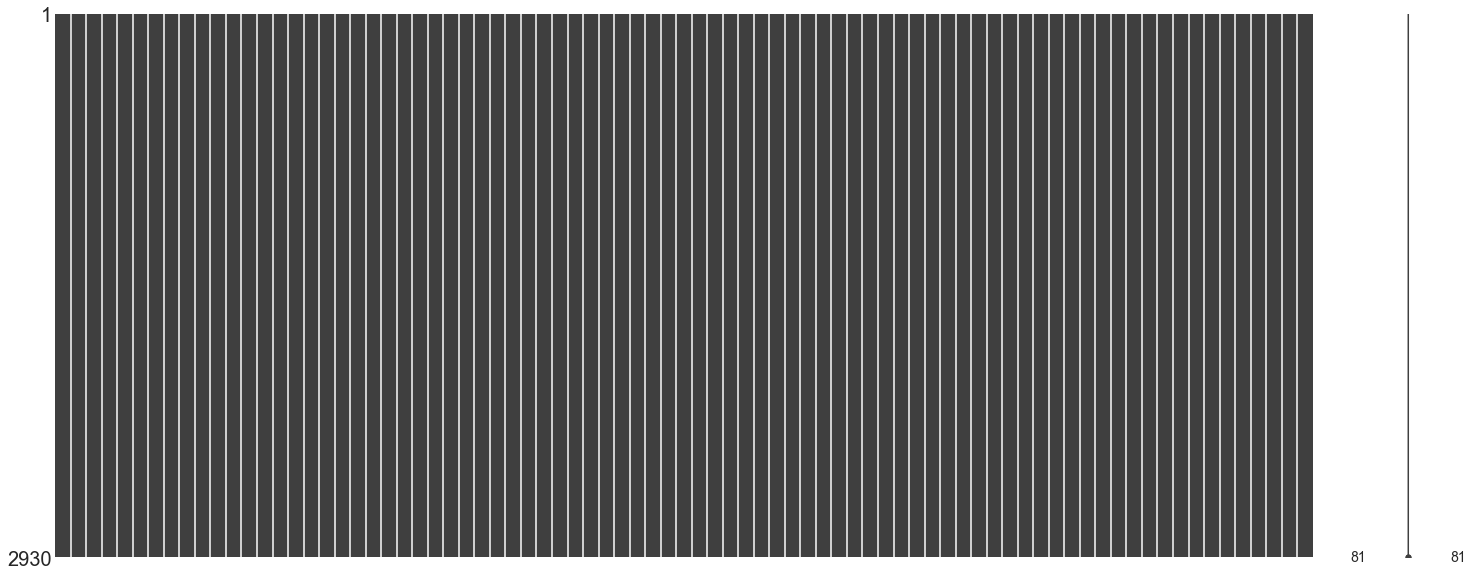

In [4]:
msno.matrix(df)

#### - Vector objetivo

<AxesSubplot:xlabel='Sale_Price', ylabel='Density'>

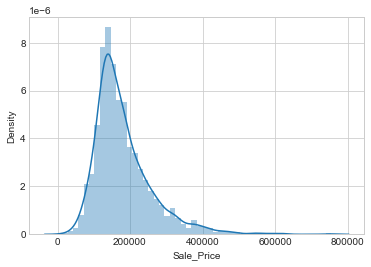

In [5]:
sns.distplot(df['Sale_Price'])

#### - Atributos y Vector

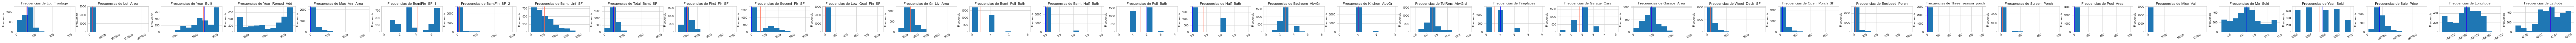

In [6]:
grafestad_numbers(df,20)

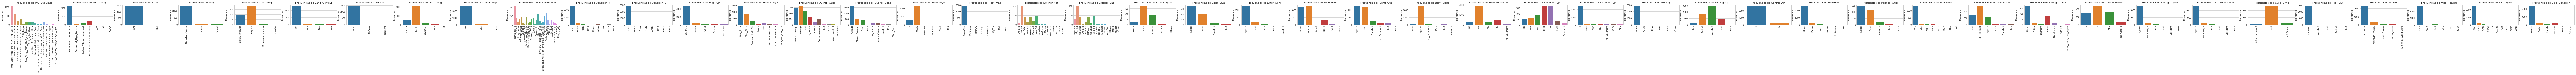

In [7]:
grafestad_object(df,26)

#### Ejercicio 2: Feature engineering
* Identifique si el dtype de cada pd.Serie en nuestra base de datos se considera 'object' o no. Para todas las variables que sean 'object', realice lo siguiente:
    1. Genere una recodificación $K-1$ en cada variable. Para efectos prácticos sólo necesitan eliminar una de las categorías, no se concentren en especificar la categoría a eliminar. Pueden utilizar la función pd.get_dummies con la opción drop_first para ello.
    2. Utilizando el método pd.concat , concatene a los atributos creados en la base de datos. 


* tip: No se olvide de eliminar los atributos recodificados, de esta forma evitará un aumento artificial del desempeño del modelo.

In [8]:
for col in df:
    if df[col].dtype == 'object':
        df = pd.concat([df, pd.get_dummies(df[col], drop_first=True, prefix=col)], axis=1)
        df = df.drop(columns=col)

In [9]:
df.head()

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0
2,81,14267,1958,1958,108,1,0,406,1329,1329,...,0,0,0,0,1,0,0,0,1,0
3,93,11160,1968,1968,0,1,0,1045,2110,2110,...,0,0,0,0,1,0,0,0,1,0
4,74,13830,1997,1998,0,3,0,137,928,928,...,0,0,0,0,1,0,0,0,1,0


#### Ejercicio 3: Primer modelo
* Genere muestras de entrenamiento y validación con 'Sale_Price' como vector objetivo y los atributos de la base de datos como matriz.
* Recuerde definir el porcentaje de casos en la muestra de validación y una semilla pseudoaleatoria.
* Posteriormente, entrene un árbol de regresión en la muestra de entrenamiento sin modificar los hiperparámetros. Reporte las principales métricas de desempeño.
* Comente sobre el desempeño.

In [10]:
scaler = StandardScaler()

In [11]:
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)

In [12]:
df_scaled.head(3)

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type_ConLw,Sale_Type_New,Sale_Type_Oth,Sale_Type_VWD,Sale_Type_WD,Sale_Condition_AdjLand,Sale_Condition_Alloca,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Partial
0,2.488592,2.744381,-0.375537,-1.163488,0.061046,-0.975138,-0.293918,-0.268671,0.065196,1.267003,...,-0.052324,-0.298018,-0.048937,-0.018477,0.394161,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
1,0.667355,0.187097,-0.342468,-1.115542,-0.566039,0.816181,0.557582,-0.657780,-0.383893,-0.672643,...,-0.052324,-0.298018,-0.048937,-0.018477,0.394161,-0.064128,-0.090878,-0.126294,0.462878,-0.302072
2,0.697212,0.522814,-0.441674,-1.259380,0.038650,-1.422968,-0.293918,-0.348313,0.629959,0.432445,...,-0.052324,-0.298018,-0.048937,-0.018477,0.394161,-0.064128,-0.090878,-0.126294,0.462878,-0.302072


In [13]:
X = df_scaled.drop(columns=['Sale_Price'])
y = df_scaled['Sale_Price']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state= 20000)

In [15]:
dec_tree = DecisionTreeRegressor().fit(X_train, y_train)

In [16]:
y_hat = dec_tree.predict(X_test)

In [17]:
desempeño(y_test, y_hat)

- Métricas de desempeño:
MSE: 0.247
MAE: 0.2
R2 : 0.744


#### Comentarios:
Se considera que el modelo tuvo un desempeño adecuado, con bajos errores (MSE y MAE) y un $R^2$ sobre las 0.7 unidades. De esto último, se cree que el modelo permite la predicción de los datos con un bajo overfitting, lo cual aseguraría un adecuado balance entre sesgo y varianza.

#### Ejercicio 4: Importancia relativa
* Implemente el método plot_importance utilizado en la lectura para reportar la importancia relativa de los atributos.
* Comente sobre cuáles son los principales 10 atributos que afectan la predicción de Sale_Price.
* Separe éstos 10 atributos en una nueva base de datos, junto con el vector objetivo.

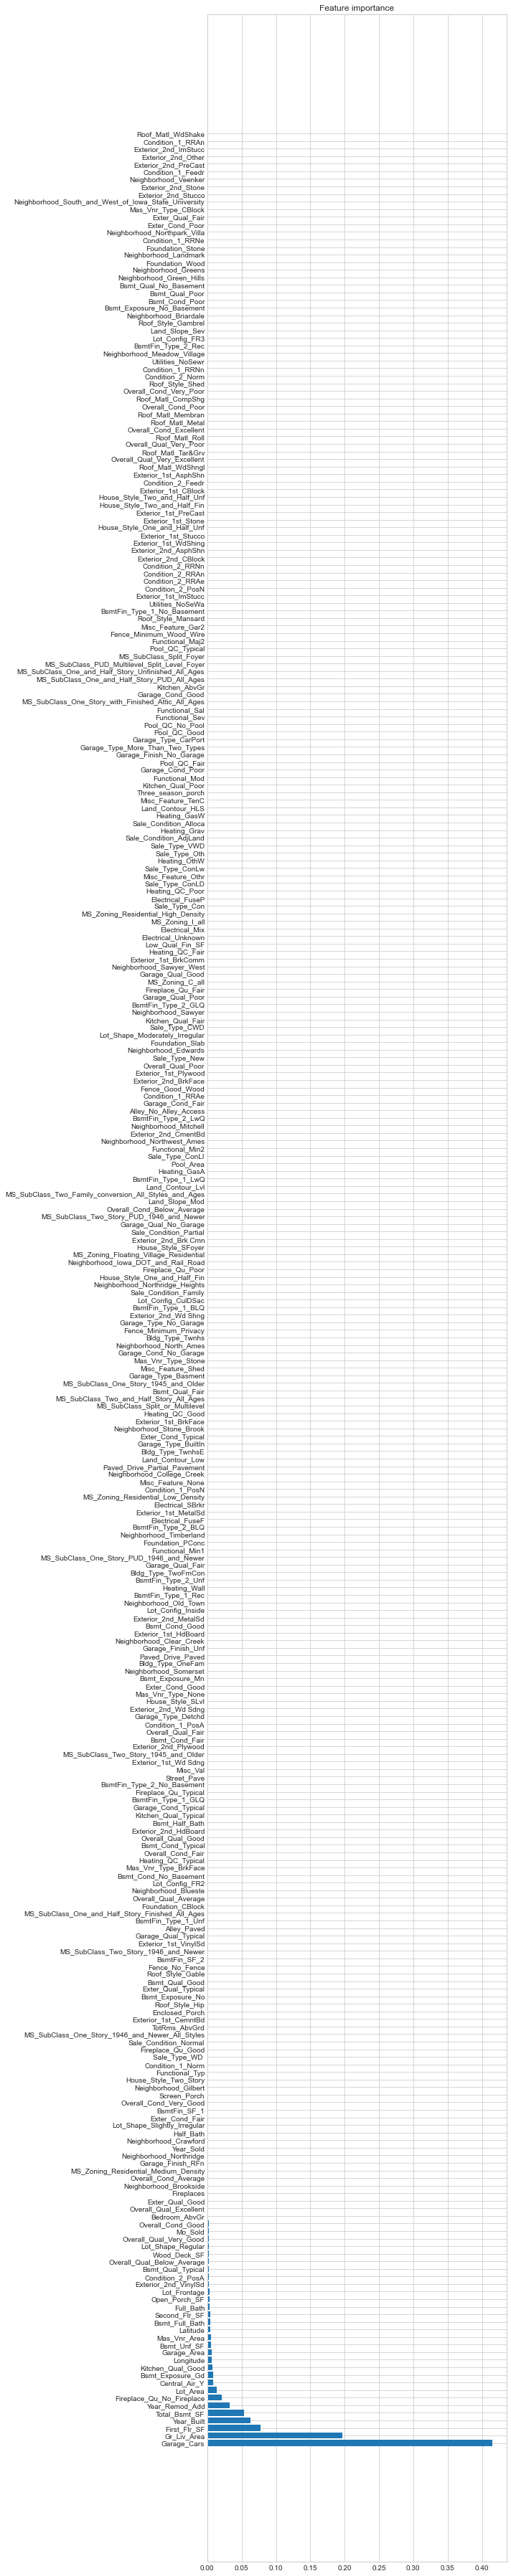

In [18]:
plt.figure(figsize=(10,50))
plot_importance(dec_tree, X.columns)
plt.tight_layout()

#### Comentarios:
* A partir de la gráfica implementada, se aprecia que los precios de venta se ven influidos y segmentados fuertemente por los siguientes 10 atributos: (En orden decreciente) 'Garage_Cars', 'Gr_Liv_Area', 'First_Flr_SF', 'Year_Built', 'Total_Bsmt_SF', 'Year_Remod_Add', 'Fireplaces', 'Lot_Area', 'Central_Air_Y' y 'Bsmt_Exposure_Gd'.
* Si bien 'Garage_Cars' y 'Gr_Liv_Area' ocupan las dos primeras mayorías, la diferencia entre ambos atributos es mayor al 100%.
* 'Garage_Cars' explica la segmentación sobre el 40%. Si bien el valor es bajo, su presencia podría generar un menor grado de overfitting de los datos.

#### Ejercicio 5: Refactorización del modelo y pickling
* En función de los atributos seleccionados en el ejercicio anterior, vuelva a generar conjuntos de entrenamiento y validación.
* Dentro de los datos de entrenamiento genere una búsqueda de grila con GridSearchCV utilizando los siguientes hiperparámetros:
    * Máximo de atributos: Evalúe todos los posibles atributos.
    * Máximo de profundidad: entre 1 a 32.
    * Validaciones cruzadas : 5.
* Reporte la mejor combinación de hiperparámetros y su desempeño asociado. Compare el desempeño en la muestra de validación con el modelo por defecto.

#### Pickling
* Ahora generaremos una serialización de nuestro modelo depurado, y nuestros conjuntos de entrenamiento y validación depurados. Para ello importe el módulo pickle.
* pickle contiene la función dump , que permite guardar el modelo desarrollado. La forma canónica para desarrollar el pickling es:

```python  
pickle.dump(<OBJETO_CON_EL_MODELO>, open('nombre-apellido-actividad07.sav','wb'))
```

* Envíe su modelo y conjuntos de entrenamiento a un compañero.

In [19]:
X_new = df_scaled.loc[:,['Garage_Cars', 'Gr_Liv_Area', 'First_Flr_SF', 'Year_Built', 'Total_Bsmt_SF', 'Year_Remod_Add', 'Fireplaces', 'Lot_Area', 'Central_Air_Y', 'Bsmt_Exposure_Gd']]
y_new = df_scaled['Sale_Price']

In [20]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, y_new, test_size = .33, random_state= 20000)

In [21]:
dec_tree_grid = GridSearchCV(DecisionTreeRegressor(),
                             {'max_depth': np.linspace(1,32,32),
                             'max_features': list(range(1, X_tr.shape[1]))},
                             cv=5, n_jobs=-1).fit(X_tr, y_tr)

In [22]:
dec_tree_grid.best_params_

{'max_depth': 10.0, 'max_features': 6}

In [23]:
dec_tree_grid.best_score_

0.7835685621858005

In [24]:
new_dec_tree = DecisionTreeRegressor(max_depth=8, max_features=8).fit(X_tr, y_tr)

In [25]:
new_y_hat = new_dec_tree.predict(X_te)

In [26]:
desempeño(y_te, new_y_hat)

- Métricas de desempeño:
MSE: 0.211
MAE: 0.185
R2 : 0.782


#### Comentarios:

* Los valores de métricas para el modelo anterior son las siguientes: MSE: 0.217, MAE: 0.207, R2 : 0.776. En este sentido, la refactorización del modelo permitió disminuir el MAE, lo cual indica que el nivel de dispersión del precio de venta mejoró gracias a que se definió un máximo de profundidad y un número máximo de características por nivel.
* Si bien el valor de $R^2$ disminuyó, se cree que parte de ello se debe a la sobre influencia del atributo 'Garage_Cars'. Sin embargo, es necesario indicar que el parámetro "best_params_", mostró desempeños muy cercanos a los vistos por el modelo sin refactorización.
* Dado el contexto actual, la presencia de sesgo requiere mayor análisis, dada la contribución discutida anteriormente por "Garage_Cars" y las nuevas métricas obtenidas.

In [27]:
pickle.dump(new_dec_tree, open('juanpablo-ramirez-actividad07.sav','wb'))

In [28]:
pickle.dump([X_tr, X_te, y_tr, y_te], open('jpro-train-actividad07.sav','wb'))